In [1]:
import sys
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install tensorflow

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import csv
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.layers import LSTM

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta


In [1]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Import data

In [4]:
mbb_df = yf.download("MBB", start="2014-01-01", end="2024-06-01")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%%**********************]  1 of 1 completed


In [5]:
mbb_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2014-01-02,81.73,104.76,104.85,104.65,104.73,353200
2014-01-03,81.65,104.64,104.84,104.63,104.63,311000
2014-01-06,81.85,104.77,104.98,104.77,104.88,456000
2014-01-07,81.97,105.04,105.09,104.95,105.03,623900
2014-01-08,81.77,105.01,105.01,104.76,104.78,233500
...,...,...,...,...,...,...
2024-05-24,90.76,90.92,91.11,90.80,91.06,795000
2024-05-28,90.30,91.14,91.18,90.55,90.60,1883400
2024-05-29,89.95,90.37,90.37,90.03,90.25,1533800


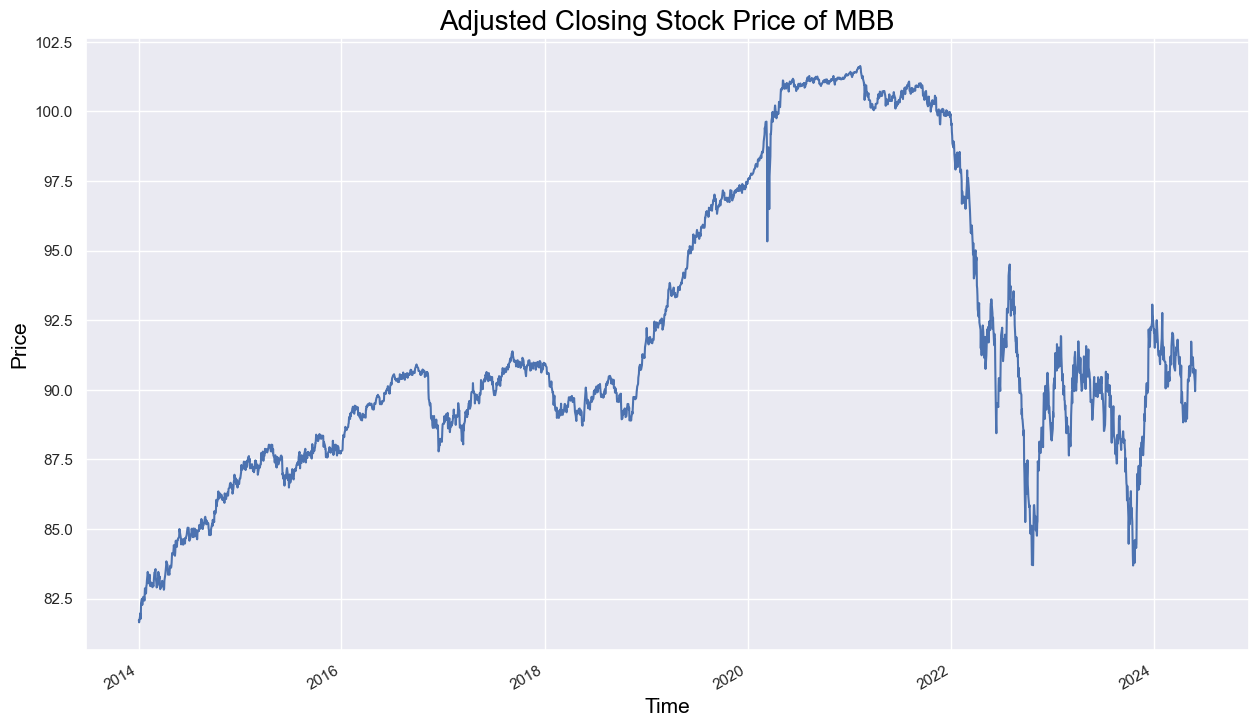

In [6]:
mbb_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Adjusted Closing Stock Price of MBB', color = 'black', fontsize = 20)
plt.xlabel('Time', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15);

## OHLC Chart
I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day.

In [6]:
df = pd.read_csv("D:/final_ML/MBB_data.csv")

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [7]:
mbb_adj = mbb_df[['Adj Close']]
mbb_adj 

,Adj Close
Date,
2014-01-02,81.73
2014-01-03,81.65
2014-01-06,81.85
2014-01-07,81.97
2014-01-08,81.77
...,...
2024-05-24,90.76
2024-05-28,90.30
2024-05-29,89.95



### Split dữ liệu

In [8]:
# Tạo split tỉ lệ 80%/20%

split = int(0.8*len(mbb_adj))

In [9]:
# Chia thành train và test set

train, test = mbb_adj[:split], mbb_adj[split:]

In [10]:
mbb_adj.shape, train.shape, test.shape

((2621, 1), (2096, 1), (525, 1))

In [11]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2014-01-02 00:00:00'),
 Timestamp('2022-04-28 00:00:00'),
 Timestamp('2022-04-29 00:00:00'),
 Timestamp('2024-05-31 00:00:00'))

### Tạo dự đoán cho test set

In [12]:
preds = []
for i in range(0,656):
    a = train[len(train)-656+i:].sum() + sum(preds)
    b = a/656
    preds.append(b)

# Linear Regression

In [13]:
mbb_adj['Date'] = pd.to_datetime(mbb_adj.index, format='%Y-%m-%d')
mbb_adj.index = mbb_adj['Date']

In [14]:
# Tạo tập dữ liệu riêng cho giá đóng cửa điều chỉnh
mbb_adj = pd.DataFrame(index=range(0,len(mbb_df)),columns=['Date', 'Adj Close'])

for i in range(0,len(mbb_df)):
     mbb_adj['Date'][i] = mbb_df.index[i]
     mbb_adj['Adj Close'][i] = mbb_df['Adj Close'][i]

### Feature engineering 

In [15]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        if hasattr(fld.dt, n.lower()):
            df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [16]:
mbb_adj['Date'] = pd.to_datetime(mbb_adj['Date'])
add_datepart(mbb_adj, 'Date')
mbb_adj.drop('Elapsed', axis=1, inplace=True)

In [17]:
# Print cột
mbb_adj.columns

Index(['Adj Close', 'Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [18]:
# Create features
mbb_adj['mon_fri'] = 0
for i in range(0,len(mbb_adj)):
    if (mbb_adj['Dayofweek'][i] == 0 or mbb_adj['Dayofweek'][i] == 4):
        mbb_adj['mon_fri'][i] = 1
    else:
        mbb_adj['mon_fri'][i] = 0

### Split data thành train và test set 

In [19]:
split = int(0.8*len(mbb_adj))
train, test = mbb_adj[:split], mbb_adj[split:]

In [20]:
mbb_adj.shape, train.shape, test.shape

((2621, 13), (2096, 13), (525, 13))

In [21]:
X_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
X_test = test.drop('Adj Close', axis=1)
y_test = test['Adj Close']

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2096, 12), (2096,), (525, 12), (525,))

### Tạo và train mô hình Hồi quy tuyến tính


In [23]:
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

### Test model

In [24]:
preds = model.predict(X_test)

### Tính chỉ số MAE

In [25]:
mae = np.mean(np.abs(np.array(y_test)-np.array(preds)))
mae 

13.555933744469502

### Trực quan hóa các dữ liệu dự đoán và thực tế

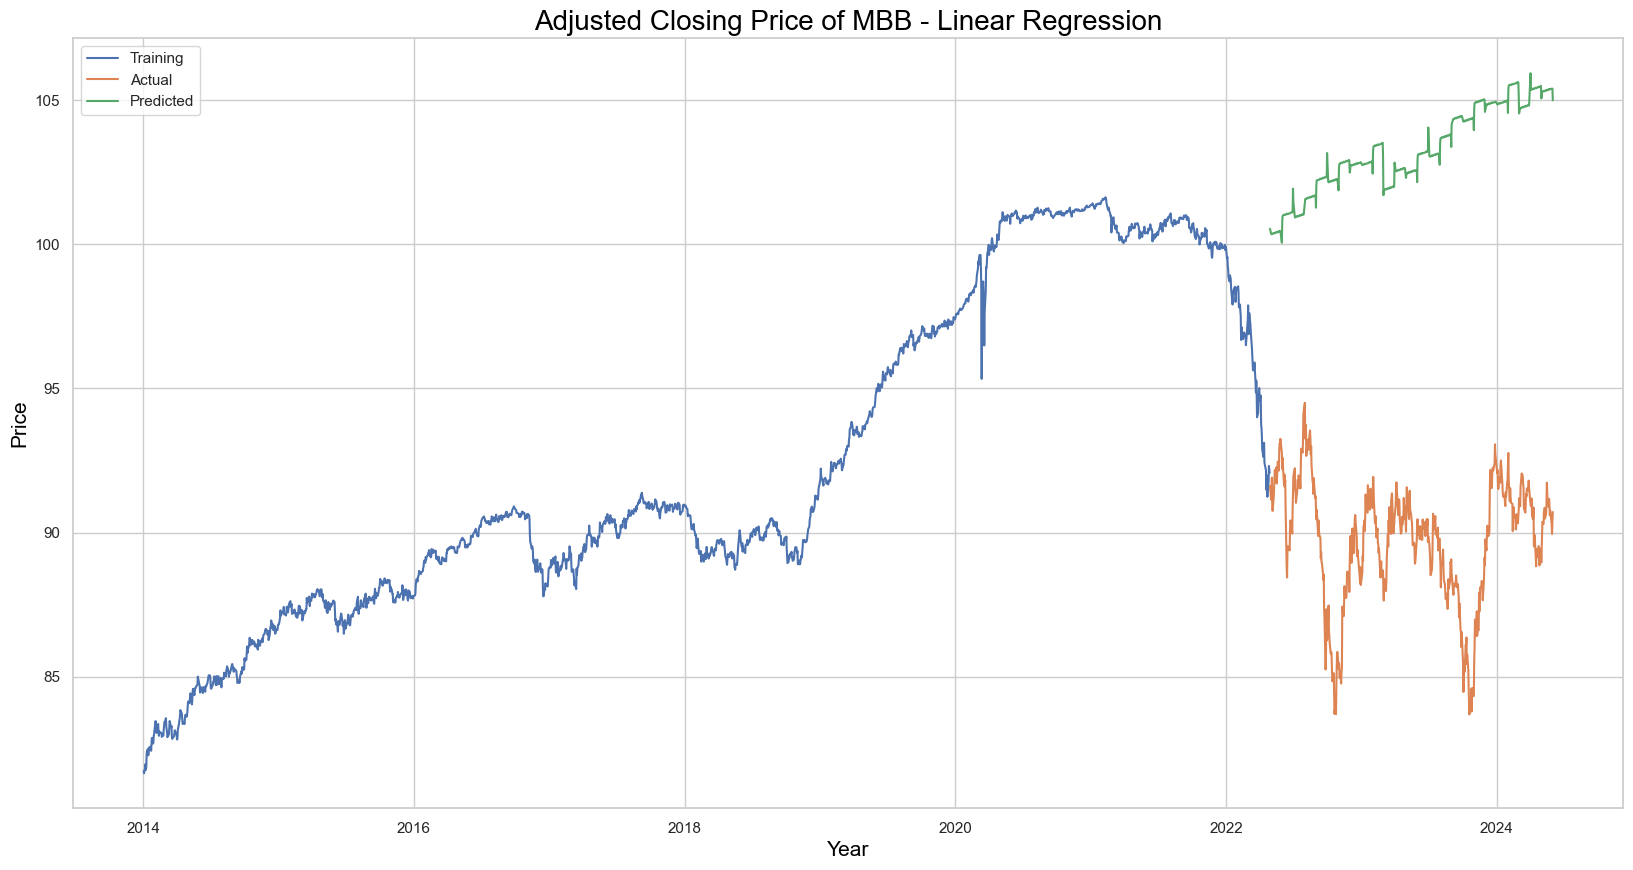

In [26]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = mbb_df[split:].index
train.index = mbb_df[:split].index

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Closing Price of MBB - Linear Regression", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();

# K-Nearest Neighbours

In [27]:
# Normalisation - rescale the data so that all values ​​are in the range 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test) 
X_test = pd.DataFrame(X_test_scaled)

### GridSearch tìm tham số tối ưu

In [28]:
# Create library for parameters
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
# Create model
knn = KNeighborsRegressor()
# Use GridSearch to find paramenters
model = GridSearchCV(knn, params, cv=5)

### Train và test model

In [29]:
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [30]:
mae = np.mean(np.abs(np.array(y_test)-np.array(preds)))
mae 

8.984901587301584

### Trực quan hóa các dữ liệu dự đoán và thực tế

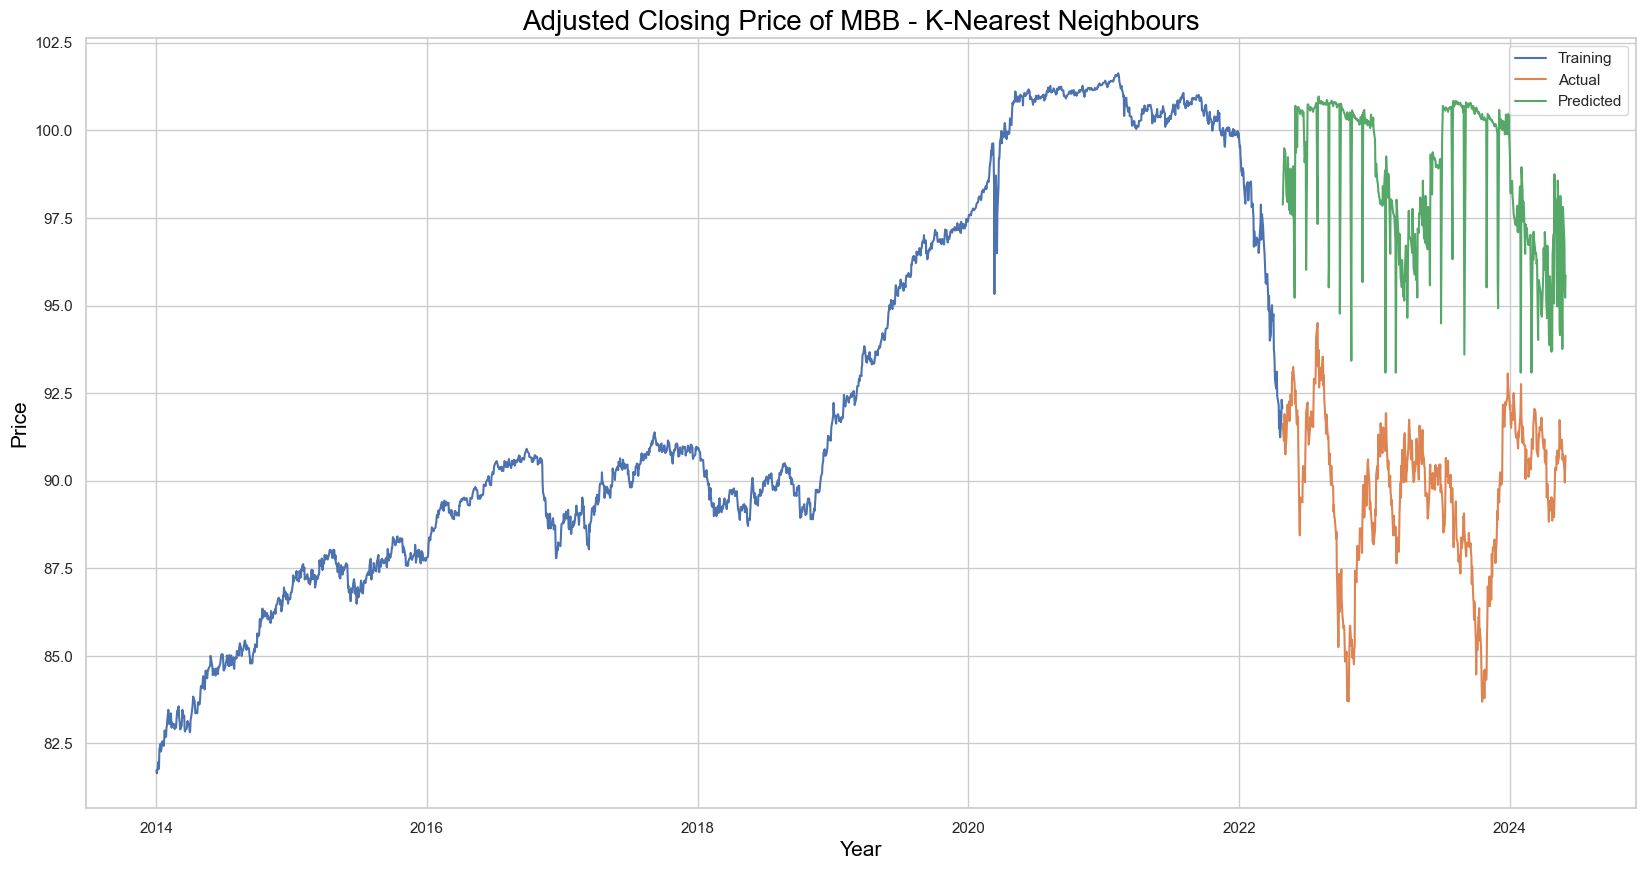

In [31]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = mbb_df[split:].index
train.index = mbb_df[:split].index

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Closing Price of MBB - K-Nearest Neighbours", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();

# Long Short Term Memory (LSTM)

In [254]:
# Tạo DataFrame cho Giá đóng cửa điều chỉnh
mbb_adj = mbb_df[['Adj Close']]
mbb_adj 

,Adj Close
Date,
2014-01-02,81.73
2014-01-03,81.65
2014-01-06,81.85
2014-01-07,81.97
2014-01-08,81.77
...,...
2024-05-24,90.76
2024-05-28,90.30
2024-05-29,89.95


In [255]:
# Chuyển DataFrame thành numpy array
mbb_adj_arr = mbb_adj.values
mbb_adj_arr

array([[81.73],
       [81.65],
       [81.85],
       ...,
       [89.95],
       [90.41],
       [90.71]])

### Split data thành train và test set

In [256]:
split = int(0.8*len(mbb_adj_arr))

In [257]:
train, test = mbb_adj_arr[:split], mbb_adj_arr[split:]

In [258]:
train.shape, test.shape

((2096, 1), (525, 1))

### Feature scaling

In [261]:
# Scaling trích chọn và fit dữ liệu scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(mbb_adj_arr)
scaled_data

array([[0.004004  ],
       [0.        ],
       [0.01001001],
       ...,
       [0.41541542],
       [0.43843844],
       [0.45345345]])

## Tạo dữ liệu training

In [262]:
# Create a data structure with 60 time-steps and 1 output

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [263]:
# Convert X_train and y_train to numpy arrays for LSTM training model

x_train, y_train = np.array(x_train), np.array(y_train)

In [264]:
# Convert data into 3D according to LSTM's required format (samples, time steps, features)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2036, 60, 1)

### Tạo và train model

In [265]:
# Create and fit LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# Predict 504 values, using 60 from the train data set
inputs = mbb_adj_arr [len(mbb_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

2036/2036 - 232s - 114ms/step - loss: 0.0018


### Tạo test set và test

In [266]:
# Create test data set
x_test = []
for i in range(60,inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])

# Convert data to numpy array
x_test = np.array(x_test)

# Convert data to 3-D
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
adj_closing_price = model.predict(x_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [267]:
print(x_test.shape)

(525, 60, 1)


### Tính chỉ số MAE

In [268]:
mae = np.mean(np.abs(np.array((test - adj_closing_price))))
mae

0.7326494495210192

### Trực quan hóa các dữ liệu dự đoán và thực tế

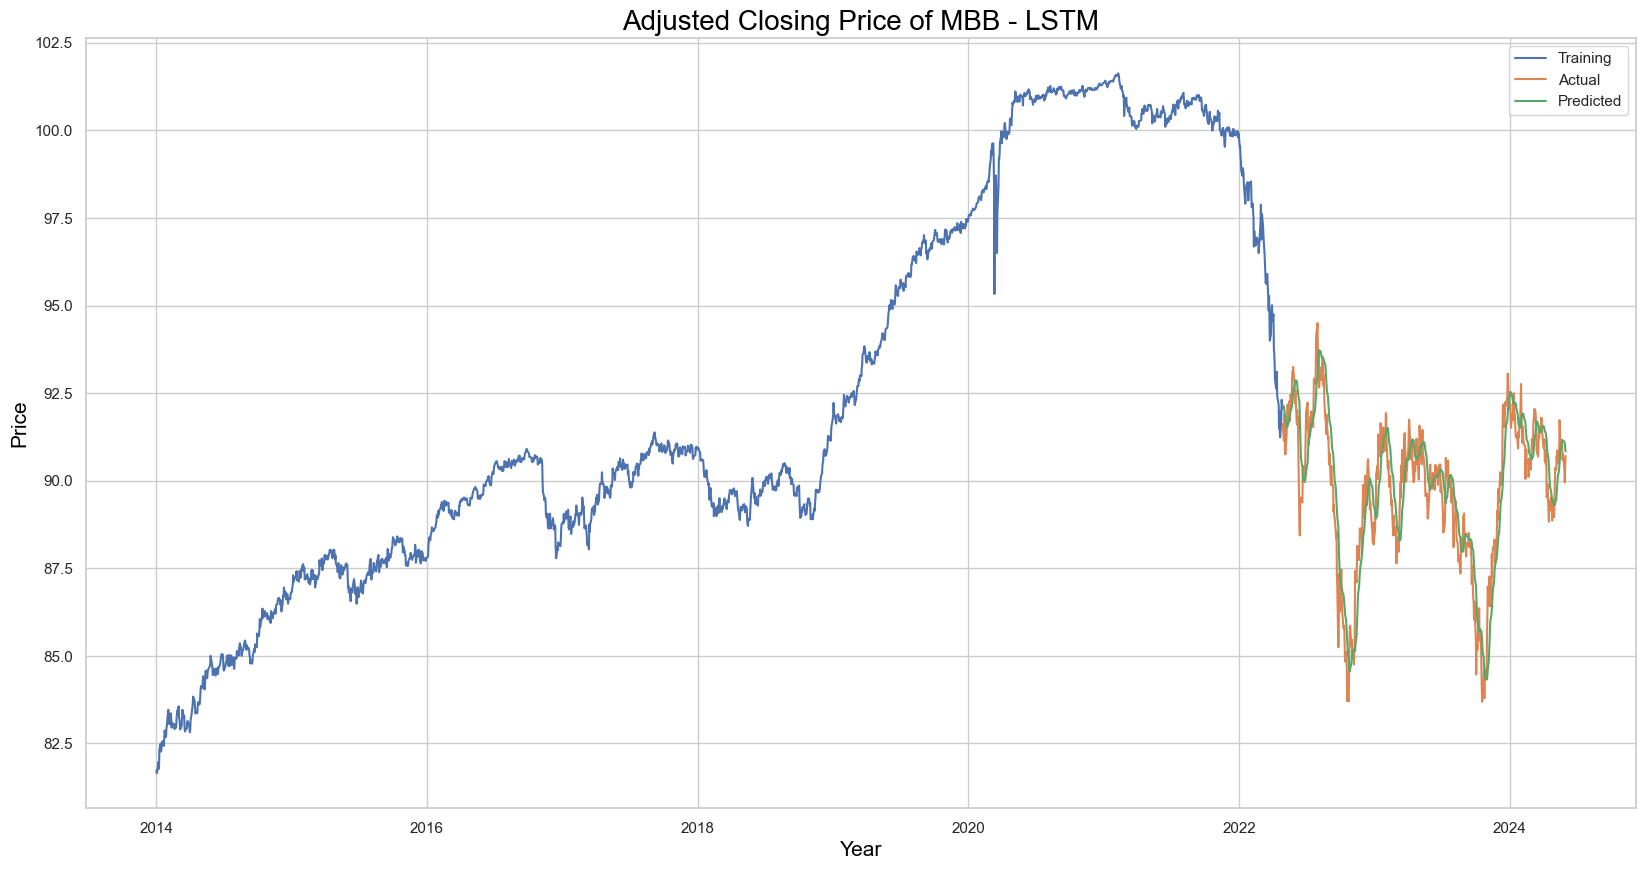

In [270]:
# Plot thông số dự đoán và thực tế
train = mbb_adj[:split]
test = mbb_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Closing Price of MBB - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();